# E5-1-2. 음성데이터 classification : 1D-Skip-Connection model
### A-1. 데이터 준비 및 분석
#### 데이터 다운 (1.6G 대용량)
- mkdir -p ~/aiffel/speech_recognition/data
- mkdir -p ~/aiffel/speech_recognition/models
- wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz 
- -P ~/aiffel/speech_recognition/data

In [1]:
#### 1. 데이터 로드 ####################################################################################
import numpy as np
import os

#data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load('speech_wav_8000.npz')
for i in speech_data:
    print(i)

wav_data = speech_data["wav_vals"]
label_data = speech_data["label_vals"]

# 1초 길이의 오디오 데이터 50620개, 1개 당 8000가지의 sample data 보유
print("Wave data shape : ", wav_data.shape) # 8000*1사이즈(데이터의 feature) 데이터 50620개 = 50620*8000 행렬
print("Label data shape : ", label_data.shape) # 데이터 개수만큼 라벨(정답지) 존재 = 50620*1 행렬

wav_vals
label_vals
Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [2]:
#### 2. 데이터 확인 ####################################################################################
import IPython.display as ipd
import random

# 데이터 50260개 중 랜덤 추출 : 라벨과 맞는지 확인
rand = random.randint(0, len(wav_data))
print("random number : ", rand)
wav_sample = wav_data[rand]  # 웨이브 데이터??
label_sample = label_data[rand]
print("Wave data shape : ", wav_sample.shape)
print("label data shape : ", label_sample.shape)
print("label : ", label_sample)
print("wave data : ")
## rate = data의 feature 수 (1초동안 재생되는 샘플 수)
ipd.Audio(wav_sample, rate=wav_sample.shape[0]) 

random number :  7057
Wave data shape :  (8000,)
label data shape :  (1,)
label :  ['no']
wave data : 


### B. train/test 데이터셋 생성
  
* sklearn의 train_test_split 함수 이용 : train data와 test data 분리  
* test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정 가능

In [3]:
#### 3. 라벨 데이터 처리 ####################################################################################
## Text 형태의 라벨 데이터에 학습에 사용 가능한 index 부여
## unknown, silence는 구분되지 않는 데이터의 라벨
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i    
label_value = new_label_value
print('Indexed LABEL : ', new_label_value)
# {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [4]:
## label = speech_data["label_vals"]를 위에 생성해준 dict.. label_value에 해당하는 값으로 변경
## 예를들어 라벨이 yes였던 걸 0으로 바꿔주는 작업
temp = []
for v in label_data:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print(label_data.shape, label_data)
## array([ 3,  3,  3, ..., 11, 11, 11])

(50620,) [ 3  3  3 ... 11 11 11]


In [5]:
#### 4. 데이터 분리 ####################################################################################
## sklearn의 train_test_split 함수 이용 : train data와 test data 분리  
## test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정 가능
from sklearn.model_selection import train_test_split

## 음성데이터를 source로 두고 분리, indexed label data를 타겟으로 두고
train_wav, test_wav, train_label, test_label = train_test_split(wav_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav.shape, test_wav.shape)  # (45558, 8000) (5062, 8000)

train_wav = train_wav.reshape([-1, 8000, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, 8000, 1])
print(train_wav.shape, test_wav.shape)  # (45558, 8000, 1) (5062, 8000, 1)

(45558, 8000) (5062, 8000)
(45558, 8000, 1) (5062, 8000, 1)


* `tf.data.Dataset`을 이용하여 데이터셋 구성 (`Tensorflow`에 포함된 데이터셋 관리 패키지)  
* 위 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줌  
* `tf.data.Dataset.from_tensor_slices` 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용  
  
* map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할  
* 첫번째 map 함수는 `from_tensor_slice` 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정  
* map 함수는 중첩해서 사용 가능  
  
* 아래와 같이, map 함수에 넘겨줄 데이터 전처리 함수를 작성해보기

In [6]:
#### 5. 데이터셋 생성 ####################################################################################
## map : dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해줌
import tensorflow as tf

## 배치사이즈 커지면 메모리 사용량 증가, 경험상 학습에는 배치사이즈가 큰 영향 안 주는 듯
batch_size = 10

## 여기선 one-hot-encoding map 사용
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
    
# for train
## 데이터를 [source, target] 쌍으로 엮어줌
## repeat(n) : n-interation per 1 ep., () means infinitely many
## #(data) / batch-size = n-interation(or n-step) per 1 ep.
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))  
train_dataset = train_dataset.map(one_hot_label) ## 원핫인코딩
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)

### C. Conv1D 모델 구현
  
- Audio 데이터는 1차원 데이터이기 때문에 Conv1D layer를 이용해서 모델을 구성
* 현재 라벨이 될 수 있는 12개의 단어 class 가지고 있음  
* 해당 class를 구분하기 위해 `multi-class classification` 필요  
* 이를 수행하기 위한 `Loss`로 `Categorical Cross-Entropy loss`를 사용할 것임

In [7]:
#### 6-1. 1D-model construction ###########################################################################
# from keras.layers import Input, Conv1D, MaxPool1D, Dropout, Flatten, Dense, BatchNormalization, Activation
# from keras import Model
# from keras.optimizers import Adam
# from keras.losses import CategoricalCrossentropy

# def wav_model(input_shape):
#     input_tensor = Input(shape=input_shape)
#     x = Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
#     x = Conv1D(32, 9, padding='same', activation='relu')(x)
#     x = MaxPool1D()(x)

#     x = Conv1D(64, 9, padding='same', activation='relu')(x)
#     x = Conv1D(64, 9, padding='same', activation='relu')(x)
#     x = MaxPool1D()(x)

#     x = Conv1D(128, 9, padding='same', activation='relu')(x)
#     x = Conv1D(128, 9, padding='same', activation='relu')(x)
#     x = Conv1D(128, 9, padding='same', activation='relu')(x)
#     x = MaxPool1D()(x)

#     x = Conv1D(256, 9, padding='same', activation='relu')(x)
#     x = Conv1D(256, 9, padding='same', activation='relu')(x)
#     x = Conv1D(256, 9, padding='same', activation='relu')(x)
#     x = MaxPool1D()(x)
#     x = Dropout(0.3)(x)

#     x = Flatten()(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     output_tensor = Dense(12)(x)
#     model = Model(input_tensor, output_tensor)
#     opt = Adam(1e-4)  # 1e-4 : 0.0001
#     model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy'])
#     return model

2. Skip-Connection model 구현
  
* 기존의 모델을 `skip-connection`이 추가된 모델로 변경해 학습을 진행  
* 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현  
* Concat을 이용한 방식으로 구현  
* `tf.concat([#layer output tensor, layer output tensor#], axis=#)`  
* 우리가 사용하는 데이터가 1차원 audio 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성

In [8]:
#### 6-2. skip-conn. model construction ##########################################################################
from keras.layers import Input, Conv1D, MaxPool1D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

def skip_model(input_shape):
    input_tensor = Input(shape=input_shape)  
    x = Conv1D(32, 9, padding='same', activation='relu')(input_tensor) 
    x = Conv1D(32, 9, padding='same', activation='relu')(x)
    skip_1 = MaxPool1D()(x)

    x = Conv1D(64, 9, padding='same', activation='relu')(skip_1)
    x = Conv1D(64, 9, padding='same', activation='relu')(x)
    x = tf.concat([x, skip_1], -1)
    skip_2 = MaxPool1D()(x)

    x = Conv1D(128, 9, padding='same', activation='relu')(skip_2)
    x = Conv1D(128, 9, padding='same', activation='relu')(x)
    x = Conv1D(128, 9, padding='same', activation='relu')(x)
    x = tf.concat([x, skip_2], -1)
    skip_3 = MaxPool1D()(x)

    x = Conv1D(256, 9, padding='same', activation='relu')(skip_3)
    x = Conv1D(256, 9, padding='same', activation='relu')(x)
    x = Conv1D(256, 9, padding='same', activation='relu')(x)
    x = tf.concat([x, skip_3], -1)
    x = MaxPool1D()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output_tensor = Dense(12)(x)
    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.Adam(1e-4)
    model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy'])
    return model

* 모델 체크포인트 저장을 위한 체크포인트의 경로 설정  
* 후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올 때 사용
- Callback
  
    * `model.fit` 함수를 이용할 때, `callback` 함수를 이용하여 학습 중간 중간 원하는 동작을 하도록 설정 가능  
    * 모델을 재사용하기 위해 모델 가중치를 저장하는 `callback` 함수 추가  
    
    * `Model Checkpoint callback`은 모델을 학습을 진행하며, `fit` 함수 내 다양한 인자를 지정해 모니터하며 동작하게 설정 가능  
    * 현재 모델은 `validation loss`를 모니터하며, `loss`가 낮아지면 모델 파라미터를 저장하도록 구성되어 있음

In [9]:
#### 7. Model Checkpoint Callback #######################################################################
checkpt_dir = 'D:/geom/Aiffel/Fourier_signal/skip_networks/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpt_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True, 
                                                 save_freq='epoch',
                                                 verbose=1)

### D. 학습
- 메모리 부족 시, 배치사이즈 줄임

In [10]:
#### 8. model fit #######################################################################################
## fit 함수는 학습결과를 리턴하고, 그 결과를 history_wav에 저장
input_shape = train_dataset.element_spec[0].shape[1:]
print(input_shape)
model = skip_model(input_shape)
history_wav = model.fit(train_dataset, epochs=10,
                    steps_per_epoch=len(train_wav) // batch_size, 
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

(8000, 1)
Epoch 1/10
4555/4555 [==============================] - ETA: 0s - loss: 1.3055 - accuracy: 0.5737
Epoch 1: val_loss improved from inf to 0.89429, saving model to D:/geom/Aiffel/Fourier_signal/skip_networks\
4555/4555 [==============================] - 393s 85ms/step - loss: 1.3055 - accuracy: 0.5737 - val_loss: 0.8943 - val_accuracy: 0.7063
Epoch 2/10
4555/4555 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.7797
Epoch 2: val_loss improved from 0.89429 to 0.69944, saving model to D:/geom/Aiffel/Fourier_signal/skip_networks\
4555/4555 [==============================] - 392s 86ms/step - loss: 0.7293 - accuracy: 0.7797 - val_loss: 0.6994 - val_accuracy: 0.7753
Epoch 3/10
4555/4555 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.8915
Epoch 3: val_loss improved from 0.69944 to 0.42264, saving model to D:/geom/Aiffel/Fourier_signal/skip_networks\
4555/4555 [==============================] - 391s 86ms/step - loss: 0.4012 - accuracy: 0.

### E. 학습 결과 시각화
- train_loss와 val_loss의 차이가 커진다면 overfitting일 수 있음
* `model.fit` 함수는 학습 동안의 결과를 return  
* return 값을 기반으로 loss와 accuracy를 그래프로 표현  
* `fit` 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 확인 가능  
* `train loss`와 `val_loss`의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있음  
* 출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인

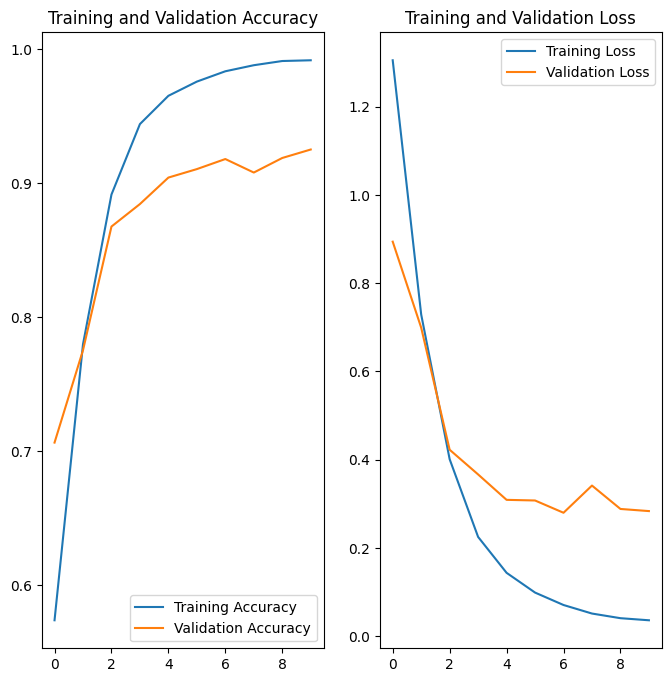

In [11]:
#### 9. accuracy, loss 비교 시각화 ###########################################################################
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### F. Evaluation (평가)
* Test dataset을 이용해서 모델의 성능 평가 : 모델의 예측값과 실제값이 얼마나 일치하는지 확인
* 실습삼아 `checkpoint callback` 함수가 저장한 weight를 다시 불러와서 테스트 준비

In [12]:
#### 10. accuracy, loss ####################################################################################
model.load_weights(checkpt_dir)
results = model.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

507/507 [==============================] - 5s 10ms/step - loss: 0.2797 - accuracy: 0.9180
loss value: 0.280
accuracy value: 91.8017%


### G. 모델 테스트
* Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인

In [13]:
#### 11. Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인 #######################################
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)
print(batch_index)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

[1874]
label :  right


In [14]:
#### 12. 테스트셋의 라벨과 모델의 실제 prediction 결과 비교 ###############################################
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + "(Correct!)")
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + "(Incorrect!)")

y_pred: right(Correct!)
